# **1.Tải dữ liệu**

In [ ]:
import zipfile, cv2, torch, os, shutil, random
import numpy as np
from PIL import Image
from google.colab import files

In [ ]:
!gdown '1R71pcVzLo3ja3XIZImrjYItsk9NwuTWu'
!unzip 'mask.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1R71pcVzLo3ja3XIZImrjYItsk9NwuTWu
From (redirected): https://drive.google.com/uc?id=1R71pcVzLo3ja3XIZImrjYItsk9NwuTWu&confirm=t&uuid=368be8dc-f87a-4a6b-98a1-b43984e9696b
To: /content/mask.zip
100% 233M/233M [00:01<00:00, 131MB/s]
Archive:  mask.zip
replace Dataset/mask_weared_incorrect/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Các đường dẫn tới thư mục chứa ảnh
with_mask_path = 'Dataset/with_mask/'
without_mask_path = 'Dataset/without_mask/'
mask_weared_incorrect_path = 'Dataset/mask_weared_incorrect'

# **2. Data augmentation**

In [ ]:
def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    value = random.uniform(0.8, 1.2)
    hsv[:,:,2] = hsv[:,:,2] * value
    hsv[:,:,2][hsv[:,:,2] > 255] = 255
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
"""
Mục đích: Điều chỉnh độ sáng của hình ảnh ngẫu nhiên trong khoảng từ 0.8 đến 1.2 lần so với độ sáng ban đầu.
Các bước thực hiện:
Chuyển đổi ảnh từ không gian màu BGR sang HSV.
Tạo một giá trị ngẫu nhiên trong khoảng từ 0.8 đến 1.2 và nhân giá trị V (độ sáng) với giá trị này.
Đảm bảo giá trị V không vượt quá 255 để tránh làm mất thông tin.
Chuyển đổi lại từ không gian màu HSV về BGR.
"""

def random_rotation(image):
    angle = random.uniform(-10, 10)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))
"""
Mục đích: Xoay ảnh một góc ngẫu nhiên trong khoảng ±10 độ.
Các bước thực hiện:
Tạo một góc ngẫu nhiên trong khoảng từ -10 đến 10 độ.
Tính ma trận xoay dựa trên góc này và trung tâm của ảnh.
Áp dụng ma trận xoay này để xoay ảnh.
"""

def random_blur(image):
    if random.random() < 0.3:  # 30% xác suất áp dụng làm mờ
        ksize = random.choice([(3, 3), (5, 5)])
        return cv2.GaussianBlur(image, ksize, 0)
    else:
        return image
"""
Mục đích: Làm mờ ảnh ngẫu nhiên bằng cách áp dụng Gaussian Blur.
Các bước thực hiện:
Nếu giá trị ngẫu nhiên nhỏ hơn 0.3, làm mờ được áp dụng; ngược lại, không làm mờ.
Chọn ngẫu nhiên kích thước của kernel (3x3 hoặc 5x5).
Áp dụng Gaussian Blur với kernel đã chọn lên ảnh.
"""

def random_noise(image):
    if random.random() < 0.3:  # 30% xác suất áp dụng nhiễu
        noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)
        return noisy_image
    else:
        return image

"""
Mục đích: Thêm nhiễu Gaussian ngẫu nhiên vào ảnh.
Các bước thực hiện:
Nếu giá trị ngẫu nhiên nhỏ hơn 0.3, nhiễu được áp dụng; ngược lại, không áp dụng.
Tạo nhiễu Gaussian với trung bình 0 và độ lệch chuẩn 25.
Thêm nhiễu vào ảnh và đảm bảo giá trị pixel nằm trong khoảng hợp lệ (0-255).
"""

'\nMục đích: Thêm nhiễu Gaussian ngẫu nhiên vào ảnh.\nCác bước thực hiện:\nNếu giá trị ngẫu nhiên nhỏ hơn 0.3, nhiễu được áp dụng; ngược lại, không áp dụng.\nTạo nhiễu Gaussian với trung bình 0 và độ lệch chuẩn 25.\nThêm nhiễu vào ảnh và đảm bảo giá trị pixel nằm trong khoảng hợp lệ (0-255).\n'

In [ ]:
def process_and_save_images():
    data = []
    labels = []

    # Các thư mục chứa ảnh với nhãn tương ứng
    for label, input_folder in enumerate([with_mask_path, without_mask_path, mask_weared_incorrect_path]):

        for filename in os.listdir(input_folder):
            if filename.endswith('.png') or filename.endswith('.jpg'):
                img_path = os.path.join(input_folder, filename)
                img = cv2.imread(img_path)

                if img is None:  # Check if image loaded successfully
                    continue  # Skip to the next image

                # Apply random augmentations that work on color images
                img = random_brightness(img)
                img = random_rotation(img)

                # Chuyển đổi ảnh về grayscale
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Apply augmentations that work on grayscale images
                img = random_blur(img)  # Apply blur randomly
                img = random_noise(img)  # Apply noise randomly

                # Resize ảnh về kích thước cố định (128x128)
                img = cv2.resize(img, (128, 128))  # Use cv2.resize for NumPy arrays

                # Chuẩn hóa giá trị pixel về khoảng [0, 1]
                img_array = np.array(img) / 255.0

                # Lưu ảnh đã xử lý vào danh sách
                data.append(img_array)
                labels.append(label)

    # Chuyển đổi danh sách thành numpy array
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    # Chuyển đổi thành tensor của PyTorch
    data_tensor = torch.tensor(data)
    labels_tensor = torch.tensor(labels)

    return data_tensor, labels_tensor

# Gọi hàm để xử lý ảnh và nhận về tensor dữ liệu và nhãn
data_tensor, labels_tensor = process_and_save_images()

print(data_tensor.shape)  # Kiểm tra kích thước của tensor dữ liệu
print(labels_tensor.shape)  # Kiểm tra kích thước của tensor nhãn

torch.Size([8982, 128, 128])
torch.Size([8982])


# **3. Train SVM**

In [ ]:
from re import X
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
data1 = data_tensor.reshape(data_tensor.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(data1, labels_tensor, stratify= labels_tensor, test_size=0.2, random_state=42)


In [ ]:
model = svm.SVC(kernel='linear')

In [ ]:
model.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (micro): {precision_micro:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (micro): {recall_micro:.4f}')
print(f'Recall (macro): {recall_macro:.4f}')
print(f'F1 score (micro): {f1_micro:.4f}')
print(f'F1 score (macro): {f1_macro:.4f}')

Accuracy: 0.5904
Precision (micro): 0.5904
Precision (macro): 0.5936
Recall (micro): 0.5904
Recall (macro): 0.5904
F1 score (micro): 0.5904
F1 score (macro): 0.5914


# **4. Train CNN**

In [ ]:
!pip install torch torchvision scikit-learn matplotlib

import os
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
def random_brightness(img):
    factor = 1.0 + (0.2 * (random.random() - 0.5))
    return cv2.convertScaleAbs(img, alpha=factor, beta=0)

def random_rotation(img):
    angle = random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def random_blur(img):
    if random.random() < 0.5:
        ksize = random.choice([3, 5, 7])
        return cv2.GaussianBlur(img, (ksize, ksize), 0)
    return img

def random_noise(img):
    if random.random() < 0.5:
        noise = np.random.randn(*img.shape) * 10
        img = img + noise
        img = np.clip(img, 0, 255)
    return img

def process_and_save_images(with_mask_path, without_mask_path, mask_weared_incorrect_path):
    data = []
    labels = []

    # Các thư mục chứa ảnh với nhãn tương ứng
    for label, input_folder in enumerate([with_mask_path, without_mask_path, mask_weared_incorrect_path]):
        for filename in os.listdir(input_folder):
            if filename.endswith('.png') or filename.endswith('.jpg'):
                img_path = os.path.join(input_folder, filename)
                img = cv2.imread(img_path)

                if img is None:  # Check if image loaded successfully
                    continue  # Skip to the next image

                # Apply random augmentations that work on color images
                img = random_brightness(img)
                img = random_rotation(img)

                # Chuyển đổi ảnh về grayscale
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Apply augmentations that work on grayscale images
                img = random_blur(img)  # Apply blur randomly
                img = random_noise(img)  # Apply noise randomly

                # Resize ảnh về kích thước cố định (128x128)
                img = cv2.resize(img, (128, 128))  # Use cv2.resize for NumPy arrays

                # Chuẩn hóa giá trị pixel về khoảng [0, 1]
                img_array = np.array(img) / 255.0

                # Lưu ảnh đã xử lý vào danh sách
                data.append(img_array)
                labels.append(label)

    # Chuyển đổi danh sách thành numpy array
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    # Thêm một chiều cho kênh màu (1 kênh vì ảnh grayscale)
    data = data[:, np.newaxis, :, :]

    # Chuyển đổi thành tensor của PyTorch
    data_tensor = torch.tensor(data)
    labels_tensor = torch.tensor(labels)

    return data_tensor, labels_tensor

# Đường dẫn đến các thư mục ảnh (bạn cần thay đổi cho phù hợp với dữ liệu của bạn)
with_mask_path = '/content/Dataset/with_mask'
without_mask_path = '/content/Dataset/without_mask'
mask_weared_incorrect_path = '/content/Dataset/mask_weared_incorrect'

# Gọi hàm để xử lý ảnh và nhận về tensor dữ liệu và nhãn
data_tensor, labels_tensor = process_and_save_images(with_mask_path, without_mask_path, mask_weared_incorrect_path)

print(data_tensor.shape)  # Kiểm tra kích thước của tensor dữ liệu
print(labels_tensor.shape)  # Kiểm tra kích thước của tensor nhãn


torch.Size([8982, 1, 128, 128])
torch.Size([8982])


In [ ]:
# Chia data thành train, validation và test theo phương pháp stratified sampling
train_idx, test_idx, train_labels, test_labels = train_test_split(
    np.arange(len(labels_tensor)), labels_tensor, test_size=0.2, stratify=labels_tensor)

train_idx, val_idx, train_labels, val_labels = train_test_split(
    train_idx, train_labels, test_size=0.25, stratify=train_labels)  # 0.25 * 0.8 = 0.2

train_data = Subset(TensorDataset(data_tensor, labels_tensor), train_idx)
val_data = Subset(TensorDataset(data_tensor, labels_tensor), val_idx)
test_data = Subset(TensorDataset(data_tensor, labels_tensor), test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 16 * 16, 3)  # Fully connected layer cho 3 lớp

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)  # Reshape cho fully connected layer
        x = self.dropout(x)
        x = self.fc(x)
        return x


Epoch [1/10], Train Loss: 0.7804, Train Acc: 0.7635, Val Loss: 0.4979, Val Acc: 0.8542
Epoch [2/10], Train Loss: 0.4451, Train Acc: 0.8662, Val Loss: 0.3680, Val Acc: 0.8815
Epoch [3/10], Train Loss: 0.4092, Train Acc: 0.8799, Val Loss: 0.4127, Val Acc: 0.8776
Epoch [4/10], Train Loss: 0.3953, Train Acc: 0.8872, Val Loss: 0.4291, Val Acc: 0.8770
Epoch [5/10], Train Loss: 0.3141, Train Acc: 0.9085, Val Loss: 0.4130, Val Acc: 0.8915
Epoch [6/10], Train Loss: 0.2370, Train Acc: 0.9228, Val Loss: 0.4407, Val Acc: 0.8937
Epoch [7/10], Train Loss: 0.2427, Train Acc: 0.9265, Val Loss: 0.3749, Val Acc: 0.9009
Epoch [8/10], Train Loss: 0.1702, Train Acc: 0.9436, Val Loss: 0.3419, Val Acc: 0.9054
Epoch [9/10], Train Loss: 0.1718, Train Acc: 0.9441, Val Loss: 0.3649, Val Acc: 0.9110
Epoch [10/10], Train Loss: 0.1585, Train Acc: 0.9462, Val Loss: 0.5015, Val Acc: 0.8859


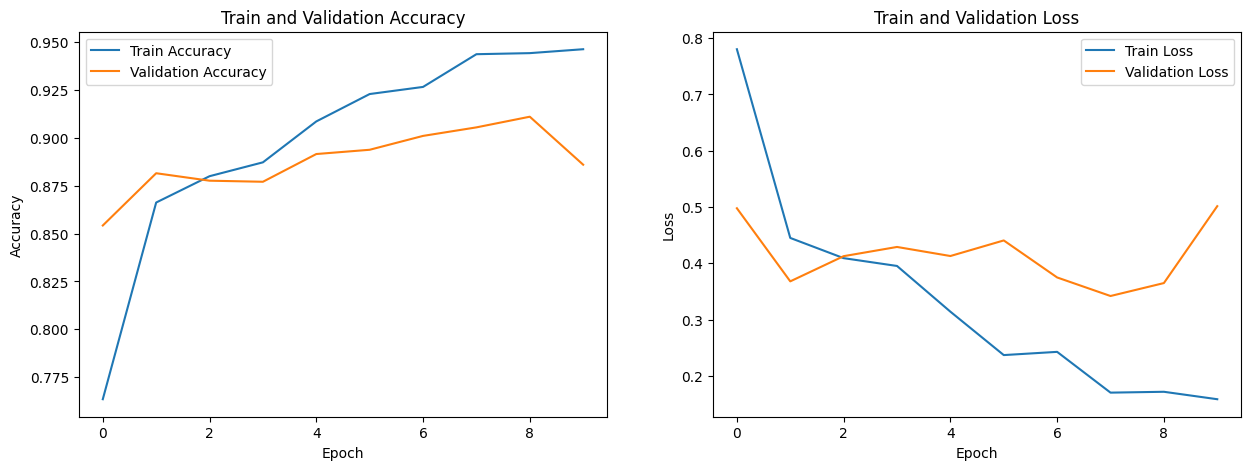

In [ ]:
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_weights = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()

        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Huấn luyện mô hình
train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10)


In [ ]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Tính toán các độ đo
accuracy = accuracy_score(all_labels, all_predictions)
precision_micro = precision_score(all_labels, all_predictions, average='micro')
recall_micro = recall_score(all_labels, all_predictions, average='micro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')

precision_macro = precision_score(all_labels, all_predictions, average='macro')
recall_macro = recall_score(all_labels, all_predictions, average='macro')
f1_macro = f1_score(all_labels, all_predictions, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (Micro): {precision_micro:.4f}')
print(f'Recall (Micro): {recall_micro:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')
print(f'Precision (Macro): {precision_macro:.4f}')
print(f'Recall (Macro): {recall_macro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')


Accuracy: 0.8820
Precision (Micro): 0.8820
Recall (Micro): 0.8820
F1 Score (Micro): 0.8820
Precision (Macro): 0.8947
Recall (Macro): 0.8820
F1 Score (Macro): 0.8835


NameError: name 'x' is not defined